In [1]:
#pip install imbalanced-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier


In [3]:
# Load the dataset
data = pd.read_csv('diabetes raw.csv')
df = pd.DataFrame(data)

# Convert 0 values in specific columns to NaN
df["Glucose"] = df["Glucose"].apply(lambda x: np.nan if x == 0 else x)
df["BloodPressure"] = df["BloodPressure"].apply(lambda x: np.nan if x == 0 else x)
df["SkinThickness"] = df["SkinThickness"].apply(lambda x: np.nan if x == 0 else x)
df["BMI"] = df["BMI"].apply(lambda x: np.nan if x == 0 else x)

# Create 'Outcome' and 'Type' columns
df['Outcome'] = 0
df.loc[(df['DiabetesPedigreeFunction'] >= 0.05) & (df['Glucose'] >= 125), 'Outcome'] = 1

conditions = [
    (df['Glucose'] >= 125) & (df['DiabetesPedigreeFunction'] >= 0.05) & (df['BMI'] >= 30) & (df['Pregnancies'] > 0),
    (df['Glucose'] >= 125) & (df['DiabetesPedigreeFunction'] >= 0.05) & (df['BMI'] >= 30) & (df['Insulin'] > 0) & (df['Pregnancies'] == 0),
    (df['Glucose'] >= 125) & (df['DiabetesPedigreeFunction'] >= 0.05) & (df['BMI'] <= 30) & (df['Pregnancies'] == 0)
]
choices = ['Gestational Diabetes', 'Type 2', 'Type 1']
df['Type'] = np.select(conditions, choices, default='No Diabetes')

# Fill NaN values
df['Glucose'].fillna(df['Glucose'].median(), inplace=True)
df['SkinThickness'].fillna(df['SkinThickness'].median(), inplace=True)
df['BMI'].fillna(df['BMI'].median(), inplace=True)
df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace=True)

# Encode target variable
label_encoder = LabelEncoder()
df['Type_encoded'] = label_encoder.fit_transform(df['Type'])

# Vertical Split
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = df['Type_encoded']

# Horizontal Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# LOGISTIC REGRESSION

Logistic Regression AUC for Gestational Diabetes: 0.9596188747731398
Logistic Regression AUC for No Diabetes: 0.9679752066115703
Logistic Regression AUC for Type 1: 0.9869281045751634
Logistic Regression AUC for Type 2: 0.9825503355704699


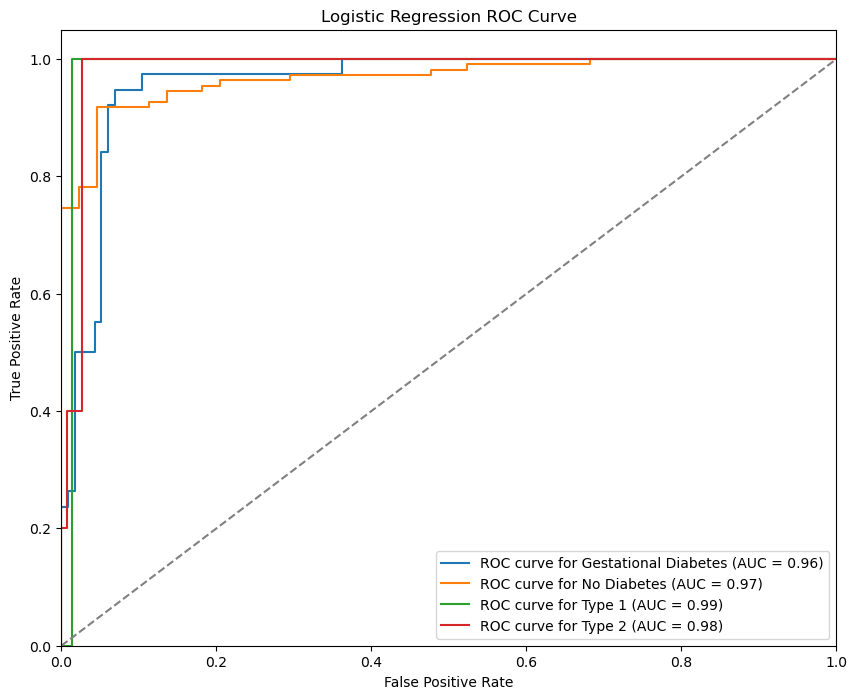

In [4]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline
pipeline_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

# Train the model
pipeline_lr.fit(X_train, y_train)

# Predict probabilities
y_pred_prob_lr = pipeline_lr.predict_proba(X_test)

# Calculate the AUC for each class
auc_scores_lr = {}
for i in range(y_pred_prob_lr.shape[1]):
    auc_scores_lr[label_encoder.classes_[i]] = roc_auc_score(y_test == i, y_pred_prob_lr[:, i])

# Print AUC for each class
for cls, score in auc_scores_lr.items():
    print(f"Logistic Regression AUC for {cls}: {score}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_pred_prob_lr.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_lr[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for {label_encoder.classes_[i]} (AUC = {auc_scores_lr[label_encoder.classes_[i]]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Support Vector Machine (SVM) Model

SVM AUC for Gestational Diabetes: 0.9816243194192378
SVM AUC for No Diabetes: 0.9828512396694216
SVM AUC for Type 1: 0.9934640522875817
SVM AUC for Type 2: 0.9838926174496645


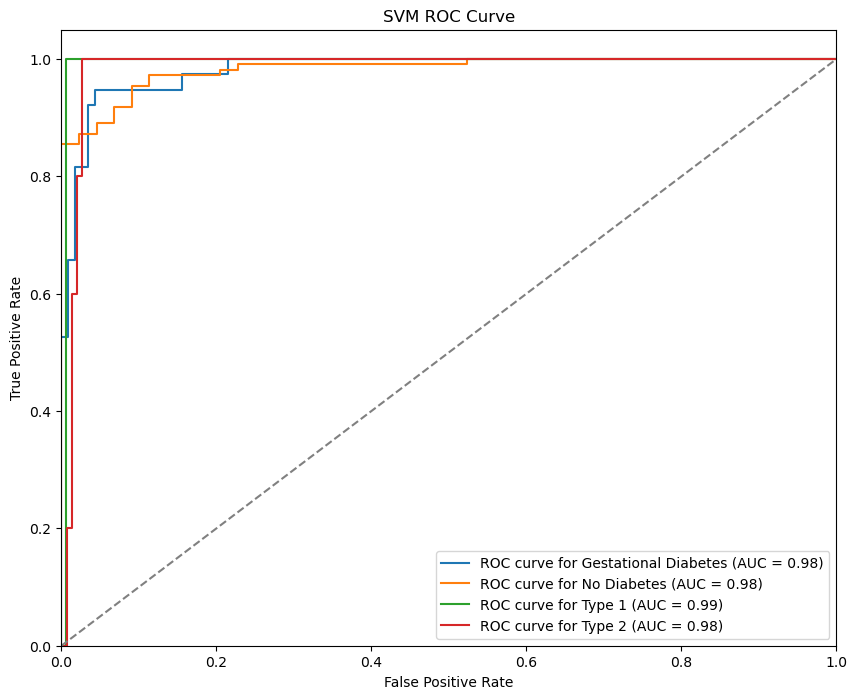

In [5]:
from sklearn.svm import SVC

# Define the pipeline
pipeline_svm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# Train the model
pipeline_svm.fit(X_train, y_train)

# Predict probabilities
y_pred_prob_svm = pipeline_svm.predict_proba(X_test)

# Calculate the AUC for each class
auc_scores_svm = {}
for i in range(y_pred_prob_svm.shape[1]):
    auc_scores_svm[label_encoder.classes_[i]] = roc_auc_score(y_test == i, y_pred_prob_svm[:, i])

# Print AUC for each class
for cls, score in auc_scores_svm.items():
    print(f"SVM AUC for {cls}: {score}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_pred_prob_svm.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_svm[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for {label_encoder.classes_[i]} (AUC = {auc_scores_svm[label_encoder.classes_[i]]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Gradient Boosting Model

Gradient Boosting AUC for Gestational Diabetes: 1.0
Gradient Boosting AUC for No Diabetes: 1.0
Gradient Boosting AUC for Type 1: 1.0
Gradient Boosting AUC for Type 2: 1.0


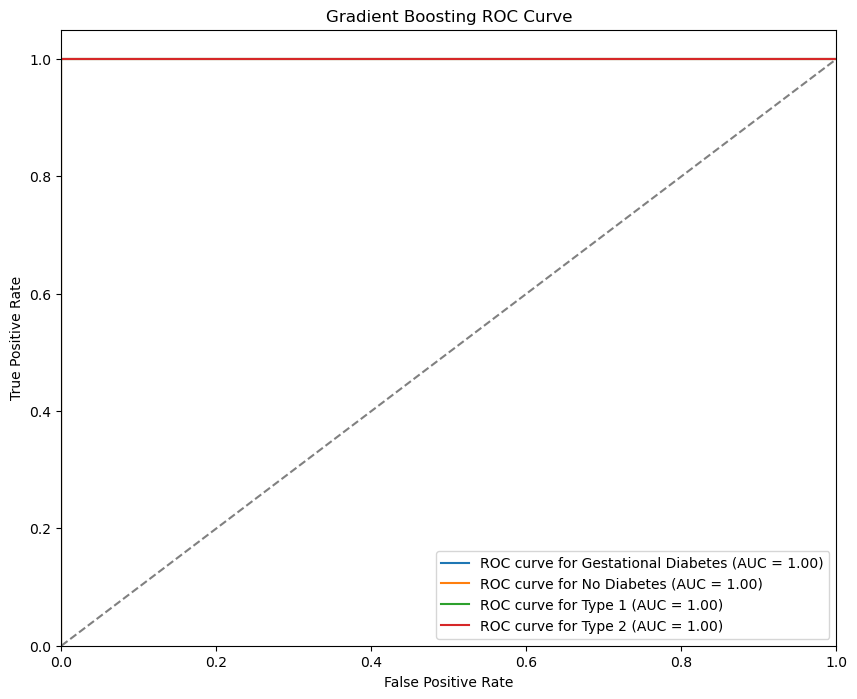

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the pipeline
pipeline_gb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train the model
pipeline_gb.fit(X_train, y_train)

# Predict probabilities
y_pred_prob_gb = pipeline_gb.predict_proba(X_test)

# Calculate the AUC for each class
auc_scores_gb = {}
for i in range(y_pred_prob_gb.shape[1]):
    auc_scores_gb[label_encoder.classes_[i]] = roc_auc_score(y_test == i, y_pred_prob_gb[:, i])

# Print AUC for each class
for cls, score in auc_scores_gb.items():
    print(f"Gradient Boosting AUC for {cls}: {score}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_pred_prob_gb.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob_gb[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for {label_encoder.classes_[i]} (AUC = {auc_scores_gb[label_encoder.classes_[i]]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Define the pipeline
pipeline_gb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Perform cross-validation
cv_scores_gb = cross_val_score(pipeline_gb, X, y, cv=5, scoring='roc_auc_ovr')

print("Cross-validated AUC scores for Gradient Boosting:", cv_scores_gb)
print("Mean AUC score for Gradient Boosting:", np.mean(cv_scores_gb))


Cross-validated AUC scores for Gradient Boosting: [0.99891484 0.99718905 1.         0.9990002  0.99922633]
Mean AUC score for Gradient Boosting: 0.9988660833726127


# Balanced Bagging and Random Forest

AUC for Gestational Diabetes: 0.9825317604355717
AUC for No Diabetes: 0.9888429752066117
AUC for Type 1: 1.0
AUC for Type 2: 1.0


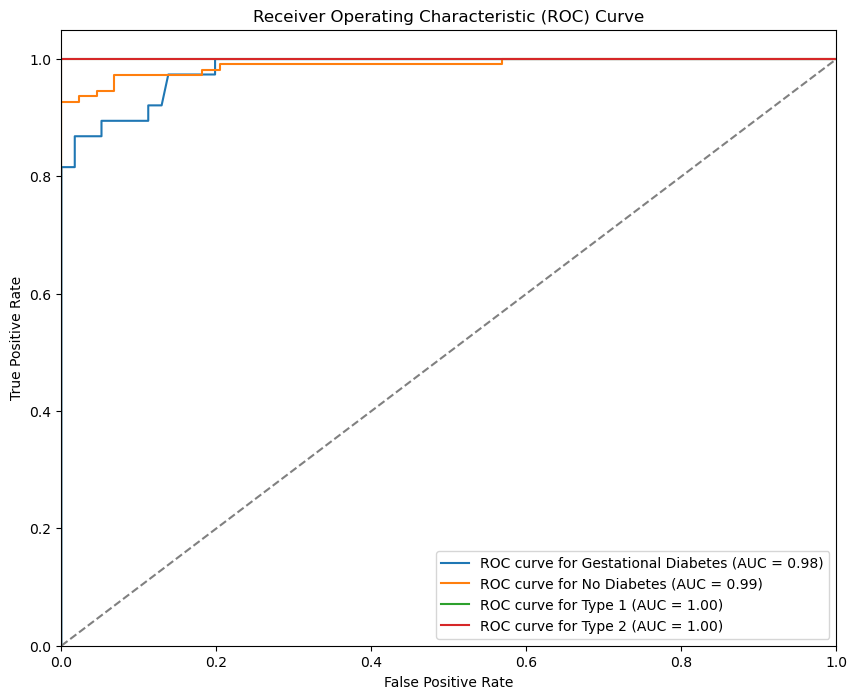

In [9]:
# Define the pipeline with Balanced Bagging and Random Forest
pipeline_rf_bb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', BalancedBaggingClassifier(base_estimator=RandomForestClassifier(random_state=42), random_state=42))
])

# Train the model on the entire dataset
pipeline_rf_bb.fit(X, y)

# Make predictions
y_pred_prob = pipeline_rf_bb.predict_proba(X_test)

# Calculate the AUC for each class
auc_scores = {}
for i in range(y_pred_prob.shape[1]):
    auc_scores[label_encoder.classes_[i]] = roc_auc_score(y_test == i, y_pred_prob[:, i])
    
# Print AUC for each class
for cls, score in auc_scores.items():
    print(f"AUC for {cls}: {score}")

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for {label_encoder.classes_[i]} (AUC = {auc_scores[label_encoder.classes_[i]]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define the scorer using AUC
auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

# Perform cross-validation
cv_scores = cross_val_score(pipeline_rf_bb, X, y, cv=5, scoring=auc_scorer)

print("Cross-validated AUC scores:", cv_scores)
print("Mean AUC score:", np.mean(cv_scores))


Cross-validated AUC scores: [0.98448083 0.97259428 0.98989105 0.97667587 0.97812968]
Mean AUC score: 0.9803543439124127


In [14]:
# Save the trained model to a file
with open('random_forest_balanced_bagging_model.sav', 'wb') as model_file:
    pickle.dump(pipeline_rf_bb, model_file)

print("Random Forest with Balanced Bagging model saved successfully.")

# Load the model from the file
with open('random_forest_balanced_bagging_model.sav', 'rb') as model_file:
    loaded_rf_bb_model = pickle.load(model_file)

# Use the loaded model to make predictions
y_pred_loaded_rf_bb = loaded_rf_bb_model.predict(X_test)
y_pred_prob_loaded_rf_bb = loaded_rf_bb_model.predict_proba(X_test)

# Evaluate the loaded model
accuracy_loaded_rf_bb = accuracy_score(y_test, y_pred_loaded_rf_bb)
print("Loaded Random Forest with Balanced Bagging Model Accuracy:", accuracy_loaded_rf_bb)

auc_scores_loaded_rf_bb = {}
for i in range(y_pred_prob_loaded_rf_bb.shape[1]):
    auc_scores_loaded_rf_bb[label_encoder.classes_[i]] = roc_auc_score(y_test == i, y_pred_prob_loaded_rf_bb[:, i])

for cls, score in auc_scores_loaded_rf_bb.items():
    print(f"Loaded Random Forest with Balanced Bagging Model AUC for {cls}: {score}")

Random Forest with Balanced Bagging model saved successfully.
Loaded Random Forest with Balanced Bagging Model Accuracy: 0.8766233766233766
Loaded Random Forest with Balanced Bagging Model AUC for Gestational Diabetes: 0.9825317604355717
Loaded Random Forest with Balanced Bagging Model AUC for No Diabetes: 0.9888429752066117
Loaded Random Forest with Balanced Bagging Model AUC for Type 1: 1.0
Loaded Random Forest with Balanced Bagging Model AUC for Type 2: 1.0


In [ ]:
df.columns

In [16]:
# Evaluate the model
#accuracy = accuracy_score(y_pred_loaded_rf_bb, y_pred)
#print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred_loaded_rf_bb, target_names=label_encoder.classes_))
print(confusion_matrix(y_test, y_pred_loaded_rf_bb))

                      precision    recall  f1-score   support

Gestational Diabetes       0.80      0.92      0.85        38
         No Diabetes       1.00      0.85      0.92       110
              Type 1       0.25      1.00      0.40         1
              Type 2       0.42      1.00      0.59         5

            accuracy                           0.88       154
           macro avg       0.62      0.94      0.69       154
        weighted avg       0.93      0.88      0.89       154

[[35  0  0  3]
 [ 9 94  3  4]
 [ 0  0  1  0]
 [ 0  0  0  5]]
